In [24]:
# Kích thước ảnh và batch size
IMG_SIZE = 64
BATCH_SIZE = 32

# Tạo dataset từ thư mục ảnh
dataset = image_dataset_from_directory(
    path,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Chuẩn hóa ảnh về [-1, 1]
dataset = dataset.map(lambda x: (x / 127.5) - 1)

# Chia train/test (80% train)
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)

print("Số batch train:", len(train_ds))


Found 1628 files.
Số batch train: 40


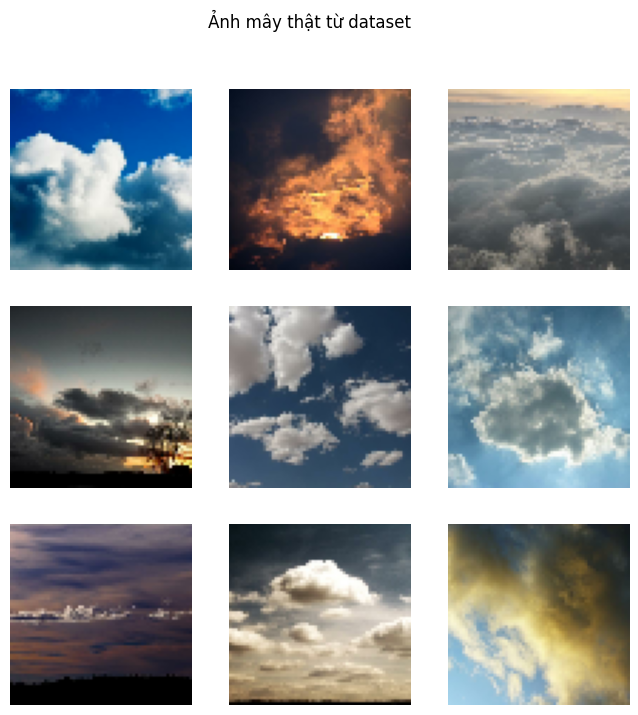

In [25]:
plt.figure(figsize=(8,8))
for batch in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((batch[i].numpy() + 1) / 2)
        plt.axis("off")
plt.suptitle("Ảnh mây thật từ dataset")
plt.show()


In [26]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()
generator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [27]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [29]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')
    plt.suptitle(f"Ảnh sinh ra sau epoch {epoch}")
    plt.show()


Epoch 1/50 | Generator Loss: 0.9772 | Discriminator Loss: 0.8912


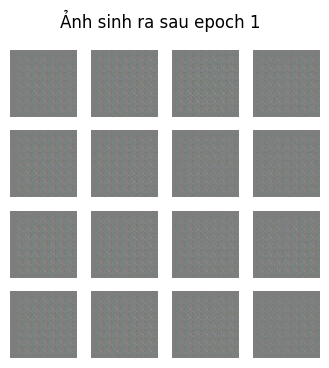

Epoch 2/50 | Generator Loss: 1.9475 | Discriminator Loss: 0.3778
Epoch 3/50 | Generator Loss: 2.8169 | Discriminator Loss: 0.1410
Epoch 4/50 | Generator Loss: 3.7098 | Discriminator Loss: 0.0921
Epoch 5/50 | Generator Loss: 4.0538 | Discriminator Loss: 0.2573
Epoch 6/50 | Generator Loss: 2.8203 | Discriminator Loss: 0.5374
Epoch 7/50 | Generator Loss: 2.6396 | Discriminator Loss: 0.4300
Epoch 8/50 | Generator Loss: 2.7024 | Discriminator Loss: 0.5222
Epoch 9/50 | Generator Loss: 3.4356 | Discriminator Loss: 0.2425
Epoch 10/50 | Generator Loss: 2.9585 | Discriminator Loss: 0.3852


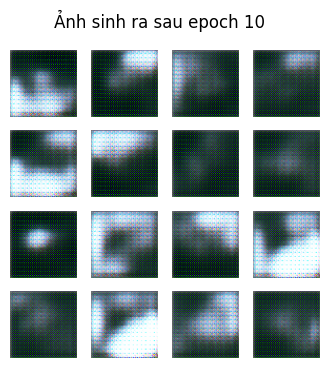

Epoch 11/50 | Generator Loss: 2.9941 | Discriminator Loss: 0.4259
Epoch 12/50 | Generator Loss: 2.8738 | Discriminator Loss: 0.4652
Epoch 13/50 | Generator Loss: 2.6203 | Discriminator Loss: 0.5333
Epoch 14/50 | Generator Loss: 2.5360 | Discriminator Loss: 0.5368
Epoch 15/50 | Generator Loss: 3.0086 | Discriminator Loss: 0.4955
Epoch 16/50 | Generator Loss: 2.7158 | Discriminator Loss: 0.5855
Epoch 17/50 | Generator Loss: 2.9096 | Discriminator Loss: 0.6596
Epoch 18/50 | Generator Loss: 3.1486 | Discriminator Loss: 0.6254
Epoch 19/50 | Generator Loss: 2.7486 | Discriminator Loss: 0.5523
Epoch 20/50 | Generator Loss: 2.0674 | Discriminator Loss: 0.9321


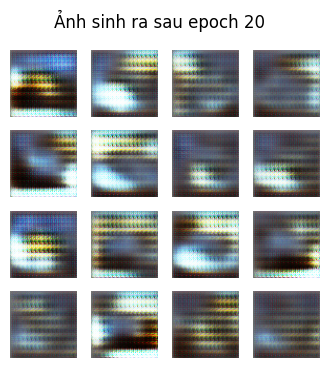

Epoch 21/50 | Generator Loss: 1.8278 | Discriminator Loss: 0.8397
Epoch 22/50 | Generator Loss: 1.4804 | Discriminator Loss: 1.0172
Epoch 23/50 | Generator Loss: 1.6321 | Discriminator Loss: 0.9051
Epoch 24/50 | Generator Loss: 1.7890 | Discriminator Loss: 0.7339
Epoch 25/50 | Generator Loss: 1.5182 | Discriminator Loss: 0.8187
Epoch 26/50 | Generator Loss: 1.3287 | Discriminator Loss: 1.0415
Epoch 27/50 | Generator Loss: 1.3538 | Discriminator Loss: 0.8487
Epoch 28/50 | Generator Loss: 1.4272 | Discriminator Loss: 0.8928
Epoch 29/50 | Generator Loss: 1.5145 | Discriminator Loss: 0.8184
Epoch 30/50 | Generator Loss: 1.5843 | Discriminator Loss: 0.6152


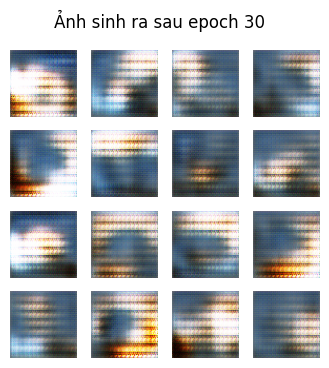

Epoch 31/50 | Generator Loss: 1.4195 | Discriminator Loss: 0.9306
Epoch 32/50 | Generator Loss: 1.4235 | Discriminator Loss: 1.3235
Epoch 33/50 | Generator Loss: 1.3846 | Discriminator Loss: 0.9360
Epoch 34/50 | Generator Loss: 1.4304 | Discriminator Loss: 0.6764
Epoch 35/50 | Generator Loss: 1.2709 | Discriminator Loss: 0.9359
Epoch 36/50 | Generator Loss: 1.0569 | Discriminator Loss: 1.3673
Epoch 37/50 | Generator Loss: 1.4815 | Discriminator Loss: 0.9191
Epoch 38/50 | Generator Loss: 1.3137 | Discriminator Loss: 0.9249
Epoch 39/50 | Generator Loss: 1.1465 | Discriminator Loss: 1.1001
Epoch 40/50 | Generator Loss: 1.2518 | Discriminator Loss: 1.1009


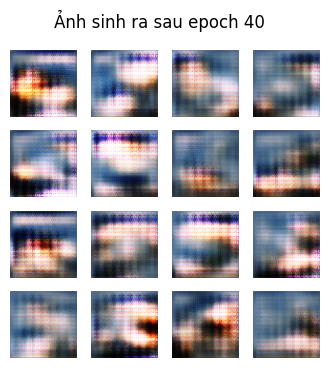

Epoch 41/50 | Generator Loss: 1.2545 | Discriminator Loss: 1.1785
Epoch 42/50 | Generator Loss: 1.3977 | Discriminator Loss: 0.9422
Epoch 43/50 | Generator Loss: 1.1859 | Discriminator Loss: 1.0841
Epoch 44/50 | Generator Loss: 1.3075 | Discriminator Loss: 0.9257
Epoch 45/50 | Generator Loss: 1.2675 | Discriminator Loss: 1.0623
Epoch 46/50 | Generator Loss: 1.4697 | Discriminator Loss: 1.0209
Epoch 47/50 | Generator Loss: 1.5959 | Discriminator Loss: 0.8254
Epoch 48/50 | Generator Loss: 1.3581 | Discriminator Loss: 0.9759
Epoch 49/50 | Generator Loss: 1.2931 | Discriminator Loss: 0.9291
Epoch 50/50 | Generator Loss: 1.1889 | Discriminator Loss: 1.0376


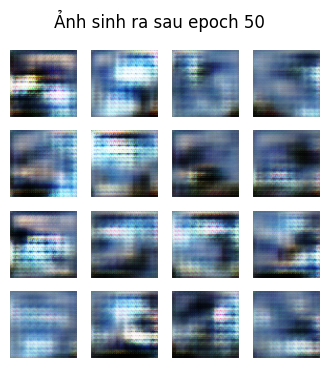

In [30]:
def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        gen_loss_list, disc_loss_list = [], []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        print(f"Epoch {epoch}/{epochs} | Generator Loss: {np.mean(gen_loss_list):.4f} | Discriminator Loss: {np.mean(disc_loss_list):.4f}")

        # Hiển thị ảnh mẫu mỗi 10 epoch
        if epoch % 10 == 0 or epoch == 1:
            generate_and_save_images(generator, epoch, seed)

train(train_ds, EPOCHS)


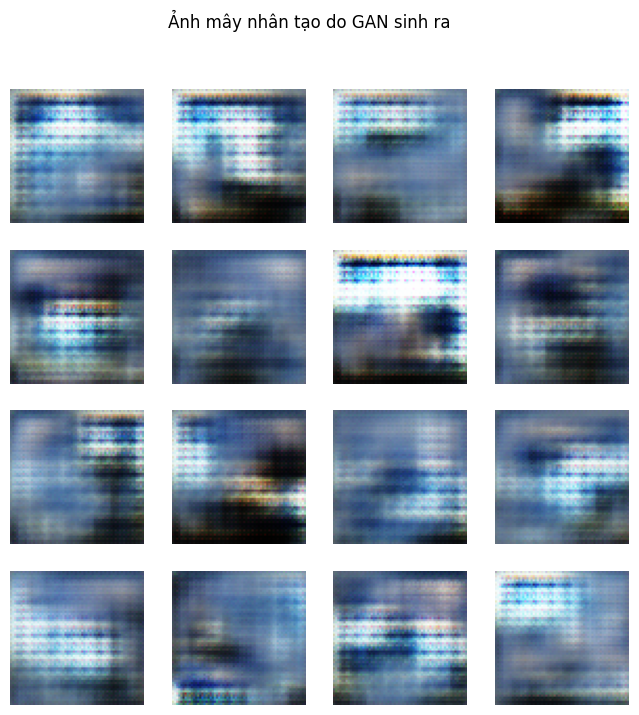

In [31]:
noise = tf.random.normal([16, noise_dim])
generated_images = generator(noise, training=False)

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((generated_images[i] + 1)/2)
    plt.axis("off")
plt.suptitle("Ảnh mây nhân tạo do GAN sinh ra")
plt.show()
